In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Nov  8 14:06:40 2023
@author: chaitrag
"""
import gym
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from torch.utils.tensorboard import SummaryWriter

ENV_NAME_2= "CartPole-v1"
input_dim =4
#ENV_NAME_3 = "MountainCar-v0"
#input_dim=2

env = gym.make(ENV_NAME_2)#, render_mode="human")

# Define hyperparameters
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
learning_rate = 0.01
batch_size = 64
memory_size = 10000
episode_length = 200
target_update_frequency = 10  # Update the target network every N episodes

# Define the Q-network
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [2]:
# Create both the main and target networks
input_dim = input_dim
output_dim = env.action_space.n
main_network = QNetwork(input_dim, output_dim)
target_network = QNetwork(input_dim, output_dim)
target_network.load_state_dict(main_network.state_dict())  # Initialize target network with main network's weights
optimizer = optim.Adam(main_network.parameters(), lr=learning_rate)

# Initialize replay memory
replay_memory = []

# Function to choose an action
def choose_action(state):
    if np.random.rand() <= epsilon:
        return env.action_space.sample()
    else:
        q_values = main_network(torch.Tensor(state))
        return torch.argmax(q_values).item()
def get_Q_network_output(state):
    return main_network(torch.Tensor(state))

In [7]:
epsilon = 1.0
# Main training loop
num_episodes = 100
writer = SummaryWriter()
for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0

    for t in range(episode_length):
        action = choose_action(state)
        next_state, reward, done, _ = env.step(action)
        total_reward += reward

        replay_memory.append((state, action, reward, next_state, done))#store experiences into replay memory
        state = next_state

        if done:
            #print(f"Episode: {episode + 1}, Total Reward: {total_reward}, Epsilon: {epsilon}")
            writer.add_scalar("Loss/train", loss, episode)
            writer.add_scalar("Total reward", total_reward,episode)
            writer.add_scalar("epsilon", epsilon, episode)
            break

        if len(replay_memory) >= batch_size:
            batch = random.sample(replay_memory, batch_size)

            for state_batch, action_batch, reward_batch, next_state_batch, done_batch in batch:
                state_batch = torch.Tensor(state_batch)
                next_state_batch = torch.Tensor(next_state_batch)

                q_values = main_network(state_batch)
                target = q_values.clone().detach()

                if not done_batch:
                    target[action_batch] = reward_batch + gamma * torch.max(target_network(next_state_batch))
                else:
                    target[action_batch] = reward_batch

                loss = nn.MSELoss()(q_values, target)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            # Decay exploration rate
            if epsilon > epsilon_min:
               epsilon *= epsilon_decay
    print(f"Episode: {episode + 1}, Total Reward: {total_reward}, Epsilon: {epsilon}")

    # Update the target network
    if episode % target_update_frequency == 0:
        target_network.load_state_dict(main_network.state_dict())
writer.close()
%load_ext tensorboard

Episode: 1, Total Reward: 27.0, Epsilon: 0.9229311239742362
Episode: 2, Total Reward: 19.0, Epsilon: 0.8433051360508336
Episode: 3, Total Reward: 17.0, Epsilon: 0.778312557068642
Episode: 4, Total Reward: 19.0, Epsilon: 0.7111635524897149
Episode: 5, Total Reward: 22.0, Epsilon: 0.6401093727576664
Episode: 6, Total Reward: 19.0, Epsilon: 0.5848838636585911
Episode: 7, Total Reward: 17.0, Epsilon: 0.5398075216808175
Episode: 8, Total Reward: 40.0, Epsilon: 0.4439551321314536
Episode: 9, Total Reward: 52.0, Epsilon: 0.3438081748424137
Episode: 10, Total Reward: 10.0, Epsilon: 0.32864265128599696
Episode: 11, Total Reward: 12.0, Epsilon: 0.31101247816653554
Episode: 12, Total Reward: 22.0, Epsilon: 0.2799384215094006
Episode: 13, Total Reward: 25.0, Epsilon: 0.24820838415550486
Episode: 14, Total Reward: 22.0, Epsilon: 0.22340924607110255
Episode: 15, Total Reward: 30.0, Epsilon: 0.19318370215794672
Episode: 16, Total Reward: 90.0, Epsilon: 0.12365869841532712
Episode: 17, Total Reward: 1

In [ ]:
%tensorboard --logdir runs

Total reward:61.8 
You can do better: Total reward did not exceed threshold of 500


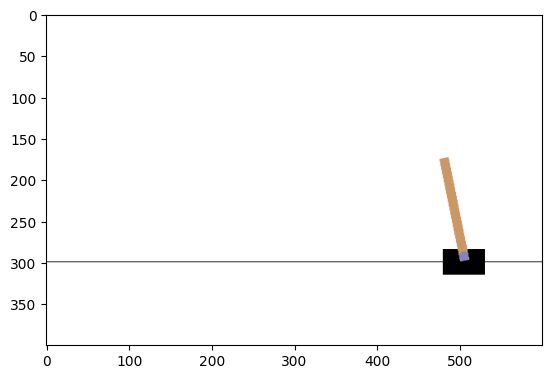

In [11]:
# Test - with vizualization
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
from pyvirtualdisplay import Display
Display().start()

epsilon = 0
TEST_EPISODES=10
total_reward = 0
img = plt.imshow(env.render('rgb_array')) # only call this once
for test_episode in range(TEST_EPISODES):
    state = env.reset()
    while True:
        img.set_data(env.render('rgb_array')) # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)
        action = choose_action(state)
        next_state, reward, done, _ = env.step(action)
        state = next_state
        total_reward += reward
        if done:
            #print(f"Episode: {test_episode + 1}, Total Reward: {total_reward}, Epsilon: {epsilon}")
            break
average_reward = total_reward / TEST_EPISODES
print(f"Total reward:{average_reward} ")
if average_reward > 200:
    print ("Good job: Total reward exceeded threshold of 200")
else:
    print ("You can do better: Total reward did not exceed threshold of 200")
#Threshold for reward for cart_pole_v1 500
env.close()